# CNN for Sentinel Images

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import random
import json

tqdm.pandas() 

rng = np.random.default_rng(342834)

In [2]:
#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

# Get ordered elevation training data
def add_elevation(order, modis):
    order = pd.DataFrame({'modis_idx': order, 'order': [x for x in range(len(order))]})
    order['station_id'] = order['modis_idx'].apply(lambda x: '-'.join(x.split('-')[:-1]))
    order = order.merge(elev_order).sort_values('order')
    ordered_elev = elevation[order['DEM_order'].to_list(), :, :]
    dim = ordered_elev.shape

    return np.concatenate([modis, ordered_elev.reshape(dim[0], 1, dim[1], dim[2])], axis=1)



In [3]:
## Sentinel Helpers
def y_merger(x, y):
    '''reattach y labels to sentinel'''
    y = y.rename(columns={"Unnamed: 0":"cell_id"})
    y = pivot_df(y, 'cell_id').dropna()
    y['date']=y['date'].map(daynum_gen)

    y['idx'] = y['cell_id'] + "-" + y['date']
    y = y.set_index('idx')

    x['idx'] = x['cell_id'] +\
         "-" +x['date_long'].astype(str)
    x = x.set_index('idx')

    return x.join(y['snowpack'])

#preprocessing helpers
def masker(x,y):
#     return x , y
    mask = np.all(x > -99, axis = (1,2))
    print(mask.sum(), "of", len(mask))
    
    return x[mask], y[mask]

def minmaxscaler(x):
    print("min", round(x.min(),3), "max", round(x.max(),3))
    x = (x - x.min())/(x.max() - x.min())
                   
    return x

def reshaper(ds):
    #readjust dimensions
    dim0 = ds.shape[0]
    dim1 = ds.shape[1]
    dim2 = ds.shape[2]

    return ds.reshape((dim0, 1, dim1, dim2))

In [4]:
y_path = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/"

train_feat = pd.read_csv(y_path + "ground_measures_train_features.csv")
test =pd.read_csv(y_path + "ground_measures_test_features.csv")
submission = pd.read_csv(y_path + "submission_format.csv")
train_y = pd.read_csv(y_path + "train_labels.csv") 
metadata = pd.read_csv(y_path + "ground_measures_metadata.csv")

## Sentinel Preprocessing

In [5]:
sent_path = "C:/Users/Matt/Dropbox/SnowComp/SentinelHelper/"

sentinel_trainfeat = np.load(sent_path + "sent_pp_trainfeat.npy")
sentinel_testfeat = np.load(sent_path + "sent_pp_testfeat.npy")
sentinel_ylabs = np.load(sent_path + "sent_pp_ylabs.npy")

trainfeat_meta = pd.read_csv(sent_path + "sent_trainfeat_meta.csv")
testfeat_meta = pd.read_csv(sent_path + "sent_testfeat_meta.csv")
ylabs_meta = pd.read_csv(sent_path + "sent_ylabs_meta.csv")

### Merge back in y labels, mask NAs

CHECK order not adjusted

In [6]:
trainfeat_meta = y_merger(trainfeat_meta, train_feat)
testfeat_meta = y_merger(testfeat_meta, test)
ylabs_meta = y_merger(ylabs_meta, train_y)

In [7]:
sentinel_ylabs, ylabs_meta = masker(sentinel_ylabs, ylabs_meta)
sentinel_trainfeat, trainfeat_meta = masker(sentinel_trainfeat, trainfeat_meta)
sentinel_testfeat, testfeat_meta = masker(sentinel_testfeat, testfeat_meta)

sentinel_ylabs = minmaxscaler(sentinel_ylabs)
sentinel_trainfeat = minmaxscaler(sentinel_trainfeat)
sentinel_testfeat = minmaxscaler(sentinel_testfeat)

min -100.0 max 18.57
min -100.0 max 19.536
min -100.0 max 14.445


## Define Training and Testing Sets


`dataset -> sentinel_ylabs`

In [8]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [9]:
#holdout 
mask = rng.random(len(sentinel_ylabs)) < 0.85

test_grid = sentinel_ylabs[~mask]
sentinel_ylabs = sentinel_ylabs[mask]

test_grid_y = ylabs_meta['snowpack'].values[~mask]
train_y = ylabs_meta['snowpack'].values[mask]

print(sentinel_ylabs.shape)
print(test_grid.shape)
print(test_grid_y.shape)
print(train_y.shape)

(64884, 41, 41)
(11526, 41, 41)
(11526,)
(64884,)


In [10]:
#training data
train_dataset = np.concatenate((sentinel_ylabs,
                   sentinel_trainfeat), axis = 0)
train_y = np.concatenate((train_y, trainfeat_meta['snowpack'].values),
                    axis = 0)

#shuffle
p =rng.permutation(len(train_dataset))
train_y = train_y[p]
train_dataset = train_dataset[p]

### Test data

In [11]:
# dataset_test = sentinel_testfeat
# y_test = testfeat_meta['snowpack'].values

#test data
dataset_test = np.concatenate((sentinel_testfeat, test_grid),
                              axis = 0) 

y_test = np.concatenate((testfeat_meta['snowpack'].values, test_grid_y),
                    axis = 0)



In [12]:
#shuffle
p =rng.permutation(len(dataset_test))
y_test = y_test[p]
dataset_test = dataset_test[p]

In [13]:
dataset_test = reshaper(dataset_test)
train_dataset = reshaper(train_dataset)

In [14]:
#@title split training and testing
training_data = train_dataset
testing_data = dataset_test
train_rows = len(training_data)
test_rows = len(testing_data)

In [15]:
#@title Get data loaders
test_x, test_y = dataset_test, y_test
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size = 256)

mini_x, mini_y = train_dataset, train_y
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

mini_dataset = TensorDataset(mini_x,
                              mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=256)

## Define CNN

In [16]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_HW = 41
START_D = 1

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2,cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(START_D, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(3, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 3)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 3)
        
        
        #third layer
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3_dim, 0, 1, 3)
        
        #fourth layer
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(flattened_dim, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim',flattened_dim)
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
#         x = torch.tanh(x)
        x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
#         x = torch.tanh(x)
        x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        
        output = self.fc2(x)
        return output

In [17]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x =x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x,as_numpy = False)
    
#     print(y.shape, outputs.shape)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)

In [18]:
#@title Setup net
cdim1=80; cdim2=30; cdim3 =15; kernel_sz=3; dropout=0.13; ldim=80; lrate = 0.0001
my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=lrate)
criterion = nn.MSELoss(reduction = 'sum')

writer = SummaryWriter('runs/sentcnn_alldata')
write_index = 0

c1 dim: 39
mp0 dim: 37
c2 dim: 35
mp1 dim: 33
c3 dim: 31
mp2 dim: 29
flattened_dim 12615


In [ ]:
N_EPOCHS = 200

test_loss = []
train_loss = []

#@title Run net
for epoch in tqdm(range(N_EPOCHS)):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         for name, param in my_nn.named_parameters():
#             print(name, param.grad.abs().sum())

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            writer.add_scalar('Loss/train', running_loss , write_index)
        write_index += 1

#     val_acc = get_accuracy(my_nn, mini_x, mini_y)
    train_loss.append(running_loss/train_rows)
    writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():
        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
        writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4) )
            
            
            
    
writer.close()
print('Finished Training')

  0%|          | 0/2000 [00:00<?, ?it/s]

0 / 2000 complete, train: 13.9107 test: 11.9233


### Checking Accuracy

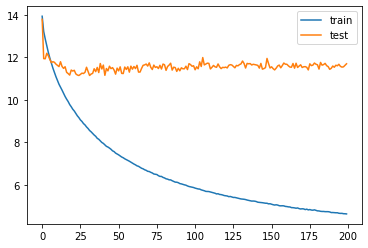

In [32]:
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

suffix = "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate)

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.plot(range(epoch+1), np.sqrt(test_loss), label ="test")
plt.legend()
plt.savefig(path +"sent_converge_alldata" + suffix+ ".png")

## Save Model and Predictions